<a href="https://colab.research.google.com/github/rodriguezdionisio/rodriguezdionisio/blob/main/Linear-Classifier-TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A linear classifier in pure TensorFlow**

Let’s come up with some nicely linearly separable synthetic data to work with: two classes of points in a 2D plane. We’ll generate each class of points by drawing their coordinates from a random distribution with a specific covariance matrix and a specific mean.

In [2]:
import numpy as np

In [3]:
num_samples_per_class = 1000

negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

In the preceding code, negative_samples and positive_samples are both arrays with shape (1000, 2). Let’s stack them into a single array with shape (2000, 2).

In [4]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

Let’s generate the corresponding target labels, an array of zeros and ones of shape (2000, 1), where targets[i, 0] is 0 if inputs[i] belongs to class 0 (and inversely).

In [5]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

Let’s plot our data with Matplotlib.

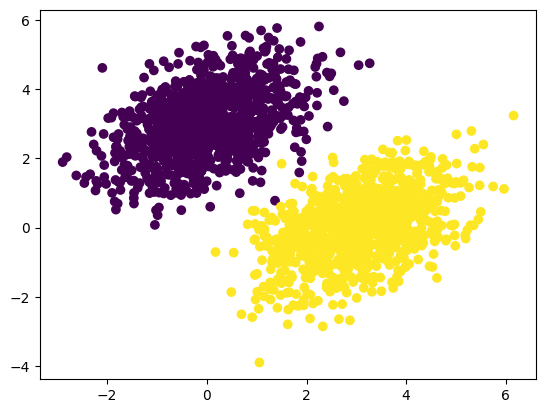

In [6]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

Now let’s create a linear classifier that can learn to separate these two blobs. A linear classifier is an affine transformation (prediction = W • input + b) trained to minimize the square of the difference between predictions and the targets.


Let’s create our variables, W and b, initialized with random values and with zeros, respectively.

In [7]:
import tensorflow as tf

input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

Here’s our forward pass function.

In [8]:
def model(inputs):
    return tf.matmul(inputs, W) + b

Because our linear classifier operates on 2D inputs, W is really just two scalar coefficients, w1 and w2: W = [[w1], [w2]]. Meanwhile, b is a single scalar coefficient. As such, for a given input point [x, y], its prediction value is prediction = [[w1], [w2]] • [x, y] + b = w1 * x + w2 * y + b.

The following listing shows our loss function.

In [9]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)


Next is the training step, which receives some training data and updates the weights W and b so as to minimize the loss on the data.

In [10]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

For simplicity, we’ll do batch training instead of mini-batch training: we’ll run each training step (gradient computation and weight update) for all the data, rather than iterate over the data in small batches. On one hand, this means that each training step will take much longer to run, since we’ll compute the forward pass and the gradients for 2,000 samples at once. On the other hand, each gradient update will be much more effective at reducing the loss on the training data, since it will encompass information from all training samples instead of, say, only 128 random samples. As a result, we will need many fewer steps of training, and we should use a larger learning rate than we would typically use for mini-batch training.

In [11]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.2565
Loss at step 1: 0.3283
Loss at step 2: 0.1398
Loss at step 3: 0.1090
Loss at step 4: 0.0993
Loss at step 5: 0.0930
Loss at step 6: 0.0874
Loss at step 7: 0.0824
Loss at step 8: 0.0778
Loss at step 9: 0.0735
Loss at step 10: 0.0696
Loss at step 11: 0.0660
Loss at step 12: 0.0627
Loss at step 13: 0.0597
Loss at step 14: 0.0569
Loss at step 15: 0.0543
Loss at step 16: 0.0520
Loss at step 17: 0.0498
Loss at step 18: 0.0478
Loss at step 19: 0.0460
Loss at step 20: 0.0443
Loss at step 21: 0.0428
Loss at step 22: 0.0413
Loss at step 23: 0.0400
Loss at step 24: 0.0388
Loss at step 25: 0.0377
Loss at step 26: 0.0367
Loss at step 27: 0.0358
Loss at step 28: 0.0349
Loss at step 29: 0.0341
Loss at step 30: 0.0334
Loss at step 31: 0.0327
Loss at step 32: 0.0321
Loss at step 33: 0.0316
Loss at step 34: 0.0311
Loss at step 35: 0.0306
Loss at step 36: 0.0301
Loss at step 37: 0.0297
Loss at step 38: 0.0294
Loss at step 39: 0.0290


After 40 steps, the training loss seems to have stabilized around 0.025. Let’s plot how our linear model classifies the training data points. Because our targets are zeros and ones, a given input point will be classified as “0” if its prediction value is below 0.5, and as “1” if it is above 0.5.

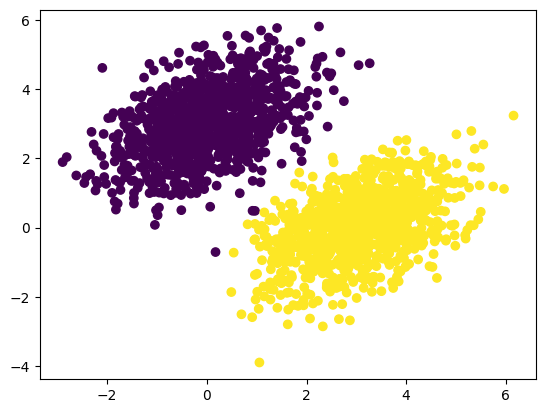

In [12]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Class 0 is defined as w1 * x + w2 * y + b < 0.5, and class 1 is defined as w1 * x + w2 * y + b > 0.5. You’ll notice that what you’re looking at is really the equation of a line in the 2D plane: w1 * x + w2 * y + b = 0.5. Above the line is class 1, and below the line is class 0.

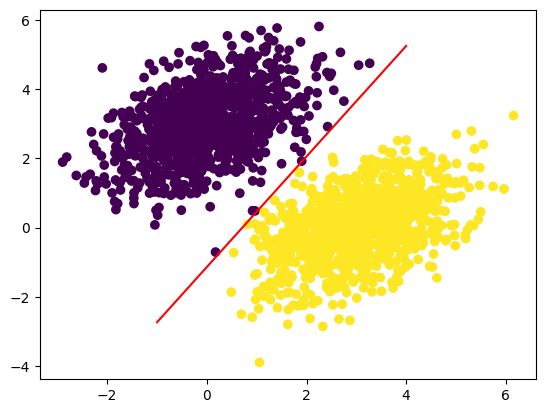

In [13]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

This is really what a linear classifier is all about: finding the parameters of a line (or, in higher-dimensional spaces, a hyperplane) neatly separating two classes of data.